# Diabetes Classification by k-Nearest Neighbors

Adjusted from [Kaggle](https://www.kaggle.com/code/shrutimechlearn/step-by-step-diabetes-classification-knn-detailed/notebook) 

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from mlxtend.plotting import plot_decision_regions
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix

%matplotlib inline

## About the Data

**Pima Indians Diabetes Database**

Dataset consist of several medical predictor (independent) variables and one target (dependent) variable, Outcome. Independent variables include the number of pregnancies the patient has had, their BMI, insulin level, age, etc.

## Loading and Exploring the Data

In [7]:
# Load data
df = pd.read_csv('diabetes.csv')

In [21]:
df.shape

(768, 9)

In [5]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


* Some features show plenty of missing values as zeros

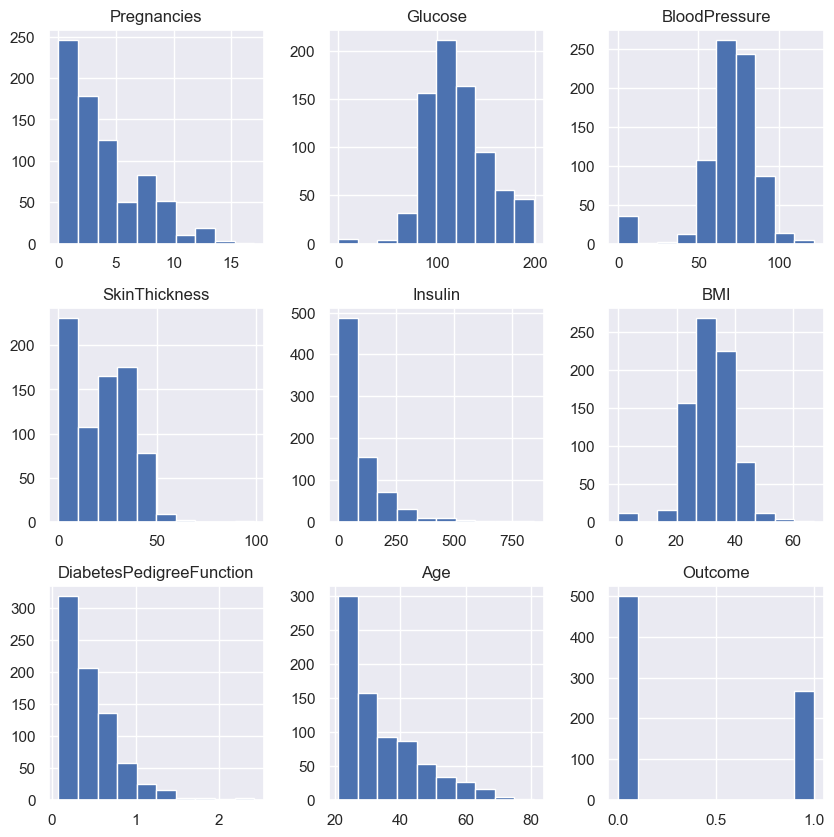

In [12]:
# Plot distribution
df.hist(figsize = (10,10));

In [13]:
# Convert zeros to missing values (NaN)
df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0, np.NaN)

In [14]:
# Count missing values (NaN)
df.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [15]:
# Impute missing values
columns_imp_mean = ['Glucose', 'BloodPressure']
columns_imp_median = ['Insulin', 'SkinThickness', 'BMI']

for col in columns_imp_mean:
    df[col].fillna(df[col].mean(), inplace = True)

for col in columns_imp_median:
    df[col].fillna(df[col].median(), inplace = True)

In [17]:
df.isnull().sum().sum()

0

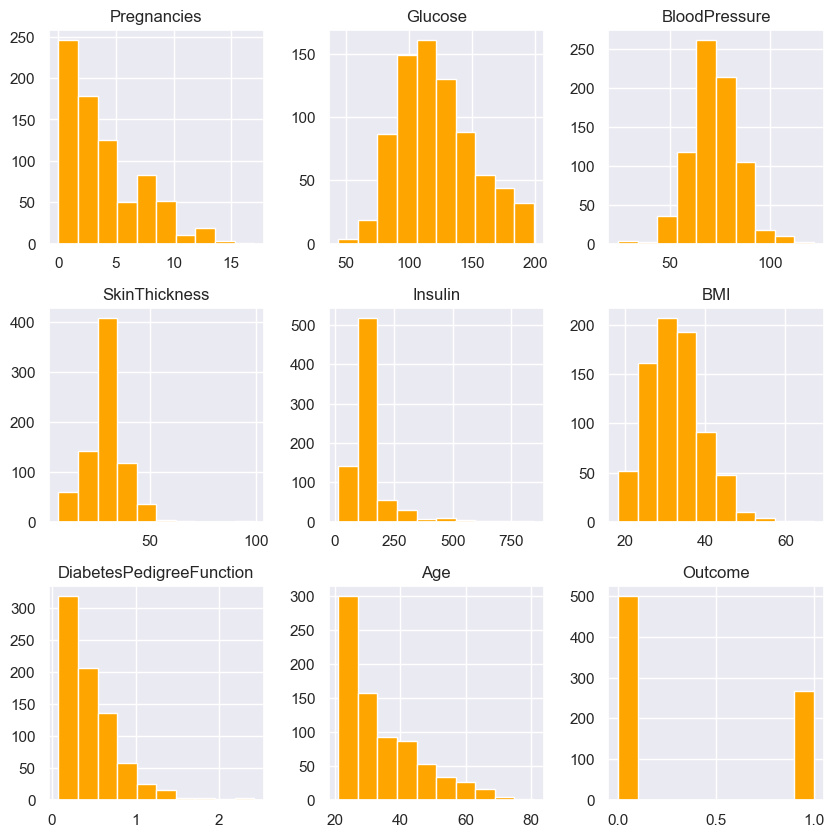

In [20]:
# Plot distribution
df.hist(figsize = (10,10), color='orange');

In [22]:
# Count non-diabetics vs. diabetics
df['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

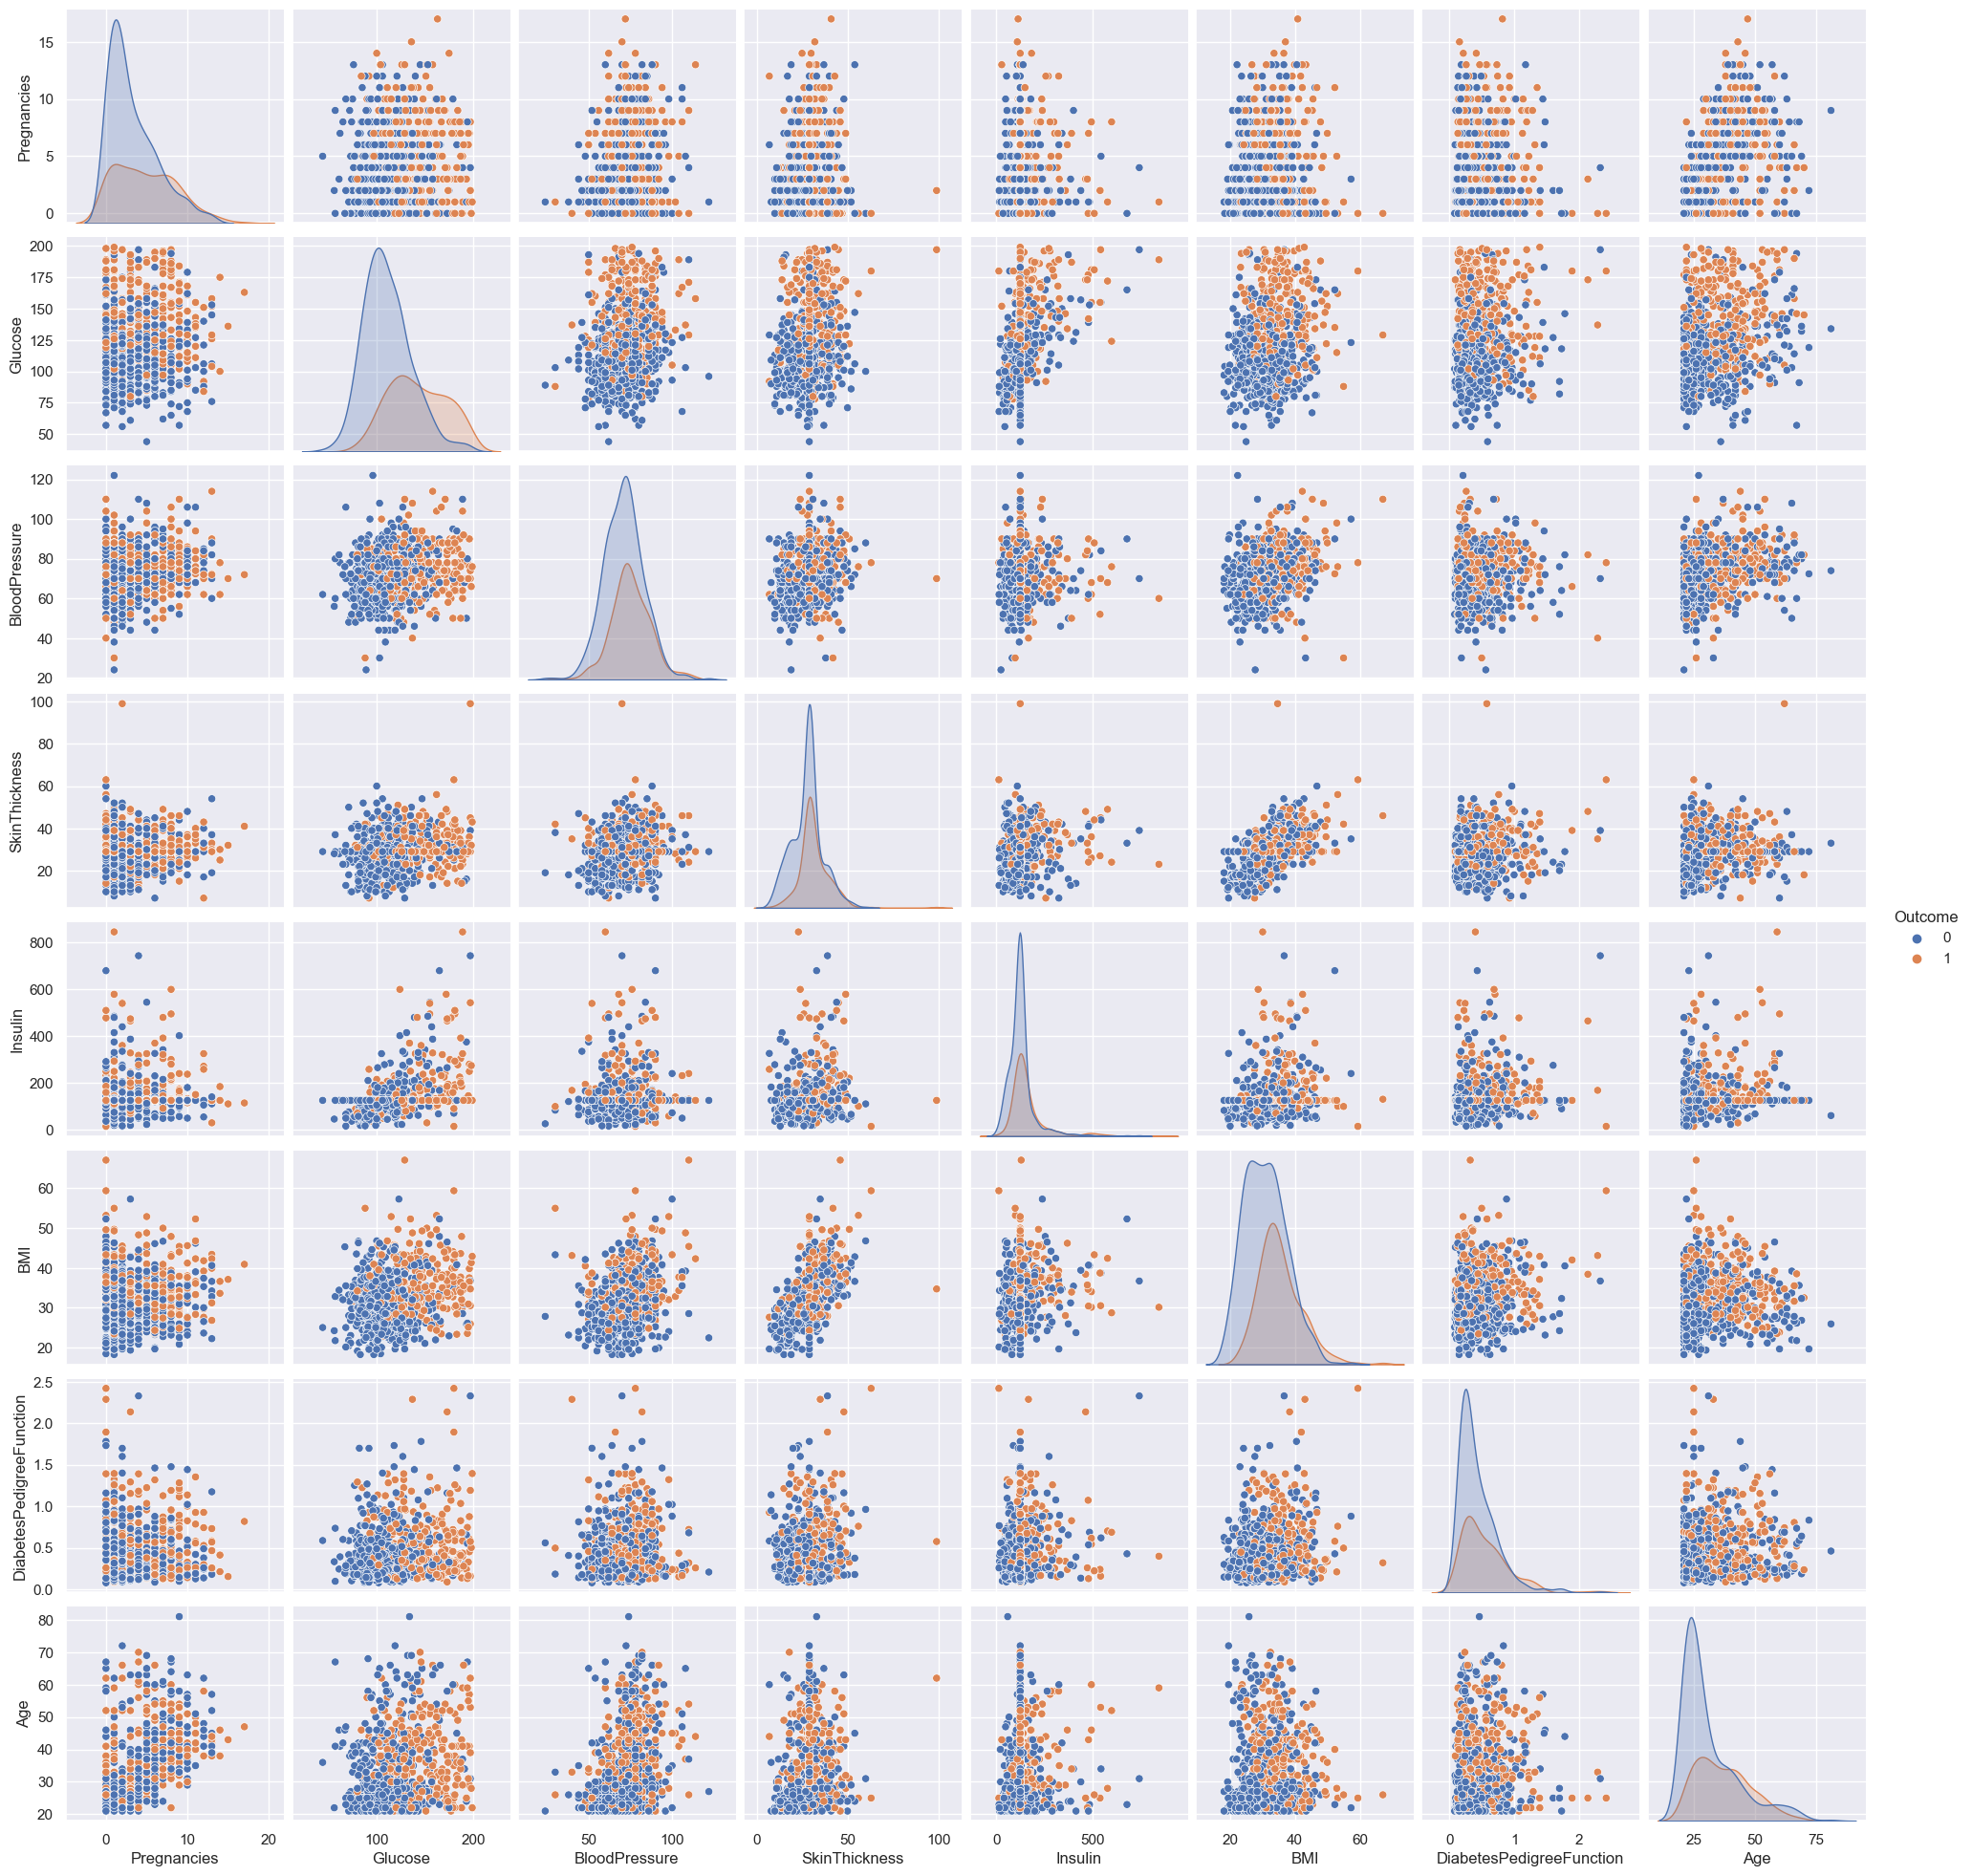

In [23]:
# Plot pairwise relationships
sns.pairplot(df, hue = 'Outcome');

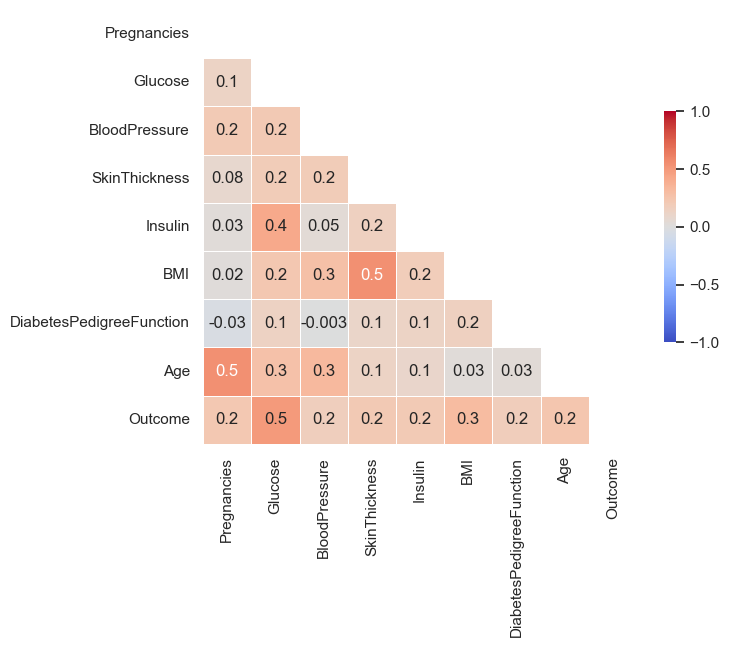

In [24]:
# Correlation heatmap
sns.set_theme(style="white")
plt.subplots(figsize=(7,6))

# Generate mask for upper triangle
mask = np.zeros_like(df.corr(), dtype=bool) #generate mask of "0's"
mask[np.triu_indices_from(mask)] = True #return upper triangle
# Set diverging colormap
cmap = sns.color_palette('coolwarm', as_cmap=True)
# Draw heatmap with mask and correct aspect ratio
sns.heatmap(df.corr(), mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0, fmt='.1g',
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True);

## Data Preparation and Modeling 

In [27]:
## Define Features X and target label y
X = df.drop(['Outcome'], axis=1)
y = df['Outcome']

In [28]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [32]:
X_train.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
751,1,121.0,78.0,39.0,74.0,39.0,0.261,28
358,12,88.0,74.0,40.0,54.0,35.3,0.378,48
718,1,108.0,60.0,46.0,178.0,35.5,0.415,24
536,0,105.0,90.0,29.0,125.0,29.6,0.197,46
651,1,117.0,60.0,23.0,106.0,33.8,0.466,27


In [33]:
# Standardize data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) # always scale X_test separately

In [34]:
pd.DataFrame(X_train_scaled, columns=['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
                                      'BMI', 'DiabetesPedigreeFunction', 'Age']).head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,-0.855471,-0.020350,0.484747,1.124727,-0.803010,0.954719,-0.658457,-0.466486
1,2.467805,-1.116897,0.158245,1.238125,-1.057352,0.405410,-0.306999,1.218656
2,-0.855471,-0.452323,-0.984509,1.918513,0.519569,0.435102,-0.195854,-0.803514
3,-1.157587,-0.552009,1.464250,-0.009253,-0.154438,-0.440824,-0.850708,1.050142
4,-0.855471,-0.153264,-0.984509,-0.689641,-0.396063,0.182717,-0.042655,-0.550743


In [65]:
## Compute training and testing accuracy scores for a variety of different neighbor values

# List of mean accuracies for k=1 to 50
train_scores = []
test_scores = []

neighbors = np.arange(1, 51)

for i, k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    
    train_scores.append(knn.score(X_train_scaled, y_train))
    test_scores.append(knn.score(X_test_scaled, y_test))

In [67]:
print(f'Max train accuracy {max(train_scores):.2f} for k={[i+1 for i, v in enumerate(train_scores) if v == max(train_scores)]}')
print(f'Max test accuracy {max(test_scores):.2f} for k={[i+1 for i, v in enumerate(test_scores) if v == max(test_scores)]}')

Max train accuracy 1.00 for k=[1]
Max test accuracy 0.76 for k=[22]


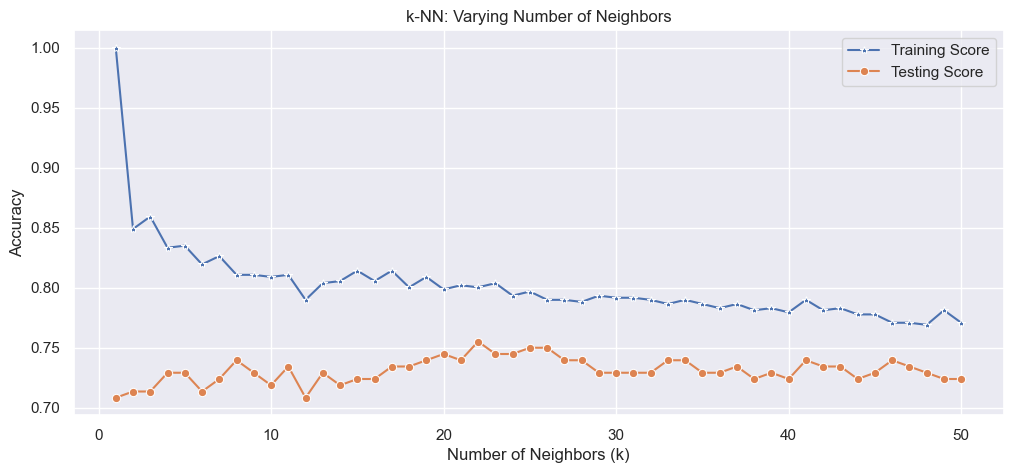

In [64]:
# Plot training and testing accuracy scores for a variety of different neighbor values
plt.figure(figsize=(12,5))
sns.lineplot(x=range(1,51),y=train_scores,marker='*',label='Training Score')
sns.lineplot(x=range(1,51),y=test_scores,marker='o',label='Testing Score')
plt.title('k-NN: Varying Number of Neighbors')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy score');

* By observing how the accuracy scores differ for the training and testing sets with different values of k, you will develop your intuition for overfitting and underfitting

In [68]:
# Setup a knn classifier with k neighbors
# Select an odd k close to k=22, here k=25
knn = KNeighborsClassifier(25)

knn.fit(X_train_scaled, y_train)
knn.score(X_test_scaled, y_test)

0.75

## Model Performance 

### 1. Confusion Matrix

In [71]:
# Confusion_matrix
y_pred = knn.predict(X_test_scaled)
confusion_matrix(y_test, y_pred)
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,108,17,125
1,31,36,67
All,139,53,192


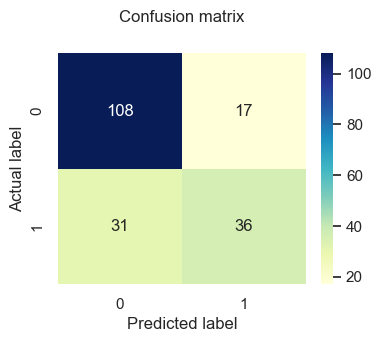

In [76]:
plt.figure(figsize=(4,3,))
cnf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label');

### 2. Classification Report

In [78]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.86      0.82       125
           1       0.68      0.54      0.60        67

    accuracy                           0.75       192
   macro avg       0.73      0.70      0.71       192
weighted avg       0.74      0.75      0.74       192



### 3. ROC - AUC

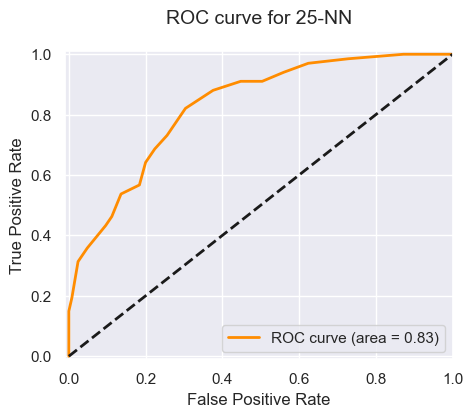

In [85]:
# Plot ROC curve for class 1 (has_diabetes)
y_pred_proba = knn.predict_proba(X_test_scaled)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba) #_: threshold
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC curve for 25-NN', pad=20, fontsize=14)
plt.legend(loc="lower right");

## Cross-Validation

In [97]:
# Perform cross-validation with GridSearchCV
param_grid = {'n_neighbors':np.arange(1,51)}
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, param_grid, cv=5) # test cv=3, 5, 10
knn_cv.fit(X_train_scaled, y_train)

print(f"Best Score: {knn_cv.best_score_:.2f}")
print(f"Best Parameters: {knn_cv.best_params_}")

Best Score: 0.77
Best Parameters: {'n_neighbors': 19}


In [98]:
param_grid

{'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])}

In [100]:
knn_cv.cv_results_['mean_test_score']

array([0.70661169, 0.68758621, 0.74136432, 0.72574213, 0.76562219,
       0.75869565, 0.74658171, 0.74830585, 0.76221889, 0.74827586,
       0.76568216, 0.76737631, 0.76397301, 0.76568216, 0.75703148,
       0.76916042, 0.76569715, 0.76569715, 0.7743928 , 0.77433283,
       0.7673913 , 0.76913043, 0.75871064, 0.7673913 , 0.77088456,
       0.76395802, 0.76745127, 0.76049475, 0.76568216, 0.76914543,
       0.76742129, 0.76566717, 0.76565217, 0.76217391, 0.76217391,
       0.75869565, 0.75176912, 0.75001499, 0.75176912, 0.75521739,
       0.75868066, 0.76215892, 0.75866567, 0.76389805, 0.76392804,
       0.76910045, 0.76044978, 0.76565217, 0.76043478, 0.75869565])

In [101]:
np.mean(knn_cv.cv_results_['mean_test_score'])

0.7586497751124438

In [102]:
np.mean(knn_cv.cv_results_['std_test_score'])

0.025071786349462926